In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import random
from itertools import chain as chain

In [3]:
data = pd.read_csv('c172_file_1.csv')
data

,AltAGL,AltB,AltGPS,AltMSL,BaroA,E1_CHT1,E1_CHT2,E1_CHT3,E1_CHT4,E1_EGT1,...,LatAc,NormAc,OAT,Pitch,Roll,TAS,VSpd,VSpdG,WndDr,WndSpd
0,0.0,855.8,745.7,833.6,30.05,231.88,224.27,243.57,245.74,1047.12,...,0.01,0.01,27.2,1.25,-0.21,0.0,-14.35,-3.9,0.0,0.0
1,0.0,856.8,746.2,834.0,30.05,232.23,224.58,243.87,246.04,1046.06,...,0.01,-0.00,27.2,1.23,-0.15,0.0,0.74,-3.9,0.0,0.0
2,0.0,855.8,746.4,834.2,30.05,232.59,224.84,244.12,246.34,1046.17,...,0.00,-0.01,27.2,1.21,-0.14,0.0,5.96,-3.9,0.0,0.0
3,0.0,856.8,745.2,833.1,30.05,232.96,225.10,244.46,246.59,1046.32,...,-0.00,-0.01,27.2,1.22,-0.14,0.0,9.95,-3.9,0.0,0.0
4,0.0,856.8,745.2,833.0,30.05,233.30,225.36,244.75,246.86,1043.91,...,0.01,-0.01,27.2,1.22,-0.10,0.0,13.36,-3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,0.0,844.2,751.5,839.3,30.02,282.56,270.85,296.29,288.37,1041.83,...,0.00,0.04,26.0,1.45,0.00,0.0,15.17,-3.9,0.0,0.0
5056,0.0,844.2,751.6,839.4,30.02,282.49,270.90,296.36,288.45,1036.33,...,0.00,-0.02,26.0,1.29,0.03,0.0,15.98,0.0,0.0,0.0
5057,0.0,844.2,751.7,839.5,30.02,282.43,270.93,296.42,288.52,1030.14,...,0.00,0.01,26.0,1.76,0.02,0.0,17.44,0.0,0.0,0.0
5058,1.0,845.2,752.4,840.2,30.02,282.55,271.14,296.58,288.66,1024.47,...,-0.00,-0.01,26.0,1.80,0.01,0.0,25.02,0.0,0.0,0.0


In [8]:
#Split and reshape the data set by step_size , use min-max or stanrdardlize method to rescale the data
def Splitting_dataset(data, step_size, scale=True, scaler_type=MinMaxScaler):
        l = len(data) 
        data = scaler_type().fit_transform(data)
        Xs = []
        Ys = []
        for i in range(0, (len(data) - step_size)):
            Xs.append(data[i:i+step_size])
            Ys.append(data[i:i+step_size])
        train_x, test_x, train_y, test_y = [np.array(x) for x in train_test_split(Xs, Ys)]
        assert train_x.shape[2] == test_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
        return  (train_x.shape[2], train_x, train_y, test_x, test_y)
    
def get_batch(x, batch_size):
    """Made with taking test_x or XX as input"""
    t = 0
    while t >= 0:
        x_mod = len(x) % batch_size
        start = random.random() * (len(x)-x_mod)
        start = int(start)
        if start + batch_size < len(x):
            t = t-1
    batch = x[start:(start+batch_size)]
    #print(batch.shape)
    return batch

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def loss_fn(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        return BCE + KLD

In [14]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=27, z_dim=31, n_flow_steps=1):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(h_dim, z_dim*2) #is it saying its getting a mu and a var for each z dim out?
            
            #how can I represent the encoder as a distribution acting as the prior?
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() 
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        return self.decoder(z), mu, logvar
    

class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
    
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [24]:
step_size= 512
batch = 512
index_step_length = 31
epochs = 10

d = 2
k = 1
#---------------------------------------------------------------------------------------------------------------------------------
labels, X, Y, XX, YY = Splitting_dataset(data, step_size)
demo = VAE(index_step_length,h_dim=7,z_dim=2)
model = R_NVP(d, k, hidden=512)
demo.double()
model.double()
optimizer = torch.optim.RMSprop(chain(demo.parameters(),model.parameters()), lr=1e-4)

C:\Users\Charlie\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/10] Loss: 21.970
Epoch[1/10] Loss: 21.831
Epoch[1/10] Loss: 21.164
Epoch[1/10] Loss: 21.079
Epoch[1/10] Loss: 21.583
Epoch[2/10] Loss: 21.462
Epoch[2/10] Loss: 21.455
Epoch[2/10] Loss: 21.612
Epoch[2/10] Loss: 21.541
Epoch[2/10] Loss: 21.130
Epoch[3/10] Loss: 20.816
Epoch[3/10] Loss: 20.933
Epoch[3/10] Loss: 20.738
Epoch[3/10] Loss: 21.318
Epoch[3/10] Loss: 20.760
Epoch[4/10] Loss: 20.541
Epoch[4/10] Loss: 20.660
Epoch[4/10] Loss: 20.690
Epoch[4/10] Loss: 21.035
Epoch[4/10] Loss: 20.978
Epoch[5/10] Loss: 20.579
Epoch[5/10] Loss: 20.594
Epoch[5/10] Loss: 19.982
Epoch[5/10] Loss: 20.377
Epoch[5/10] Loss: 20.833
Epoch[6/10] Loss: 20.457
Epoch[6/10] Loss: 20.481
Epoch[6/10] Loss: 20.158
Epoch[6/10] Loss: 20.635
Epoch[6/10] Loss: 20.133
Epoch[7/10] Loss: 20.503
Epoch[7/10] Loss: 21.407
Epoch[7/10] Loss: 20.073
Epoch[7/10] Loss: 20.304
Epoch[7/10] Loss: 19.639
Epoch[8/10] Loss: 20.217
Epoch[8/10] Loss: 20.042
Epoch[8/10] Loss: 19.991
Epoch[8/10] Loss: 19.068
Epoch[8/10] Loss: 21.766


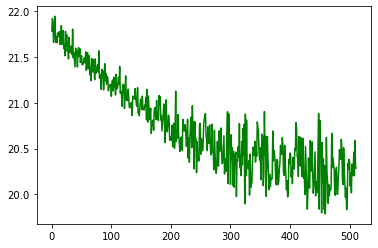

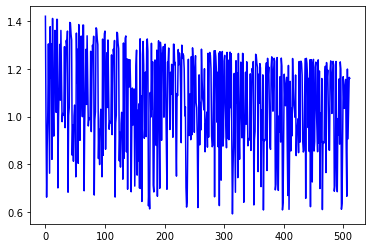

In [25]:
idx = 0

anomaly_history = []
loss_history = []
avgSum = 0
avgCount = 0

for epoch in range(epochs):
    b = get_batch(XX,batch)
    #print(range(batch))
    for i in range(batch):
        localX = torch.tensor(b[i])
        recon, mu, logvar = demo(localX)
        loss = loss_fn(recon, localX, mu, logvar) #doing kl-divergence loss correctly
        """This bound (kl loss) provides a unified objective function for 
        op-timization of both the parameters θ and φ of the model andvariational approximation, respectively."""
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx = idx + 1

        avgSum = avgSum + torch.mean(loss/batch)
        avgCount = avgCount + 1
        anomaly_score = torch.mean(localX/recon)

        if idx%10 == 0:
            loss_history.append(avgSum/avgCount)
            anomaly_history.append(anomaly_score)
            avgSum = 0
            avgCount = 0

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/batch))
p1 = plt.figure()
plt.plot(loss_history,'g-',label='h 10,z 2')
p2 = plt.figure()
plt.plot(anomaly_history,'b-',label='h 10,z 2')